# GGOR solution, transient state

@TO 2020-10-31

## Introduction
The GGOR aims to simulate simultanically time series of the average head in cross sections through mulitple, even large numbers of parcels bounded by ditches perpendicular to the plane of the cross sections. The total set of parcels and hence, cross sections, characterizes a given region in the country, usually one or more polder systems.

The theory is described in a separate document. This document together with the code and example notebooks can be found on github (github, Olsthoorn, GGOR) should suffice to locate it. 

The mentioned cross sections can be simulated both analytically and numerially (using MODFLOW). The analytical and numerical solutions can also be applied to simuate a steady-state situation. This allows us to verify the the code, at least for the steady-state case.

The GGOR python project comprises two modules `ggor_analytial.py` and `gg_modfly.py`. The first one contains the code required to analytically simulate the groundwater in single and two-layer aquifer systems, while the second coprises the code to simulate the two layer aquifer system numerically using MODFLOW.

The data of the parcel properties are normally given by shapefile in which each record holds the properties of a parcel, which is handy converted into a pandas.DataFrame for further use. For the current verification of the steady-state solution, this pandas.DataFrame needs to be only one record long. We'll define it directy in this notebook as testdata.

The time-varying data are also given as a pandas.DataFrame, whose index has pd.TimeStamps that represent true dates and times and whose columns contain the precipitation and evapotranspiration. For the current steadt-state example, only one record is required. We will generate this one-line pandas DataFrame directly in this notebook for use in the testing.

In this notbook, we will directly use python functions that implement the various solutions in transient mode. Theses functions are in the modules `ggor_analytical.py` and `gg_modflow.py` respectively. In anohter notebook, the analytic solutions for the single-layer case are directly implemented and shown to work. The analytic 2-layer solution is only described in the mentioned documentation, but is used in the current notebook.

In the current notebook, we will verify the steady state outcomes of

1. The single layer solution without regional underlying aquifer.
2. The single layer solution with regional underlying aquifer with given head.
3. The single layer solution with regional underlying aquifer with given seepage.
4. The two-layer solution with given reginal seepage.
5. The numeric MODFLOW solution with given regional seepage.

# Imports

In [5]:
# Modules
import numpy as np
import pandas as pd
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import flopy.utils.binaryfile as bf
import pdb
import os

# These lines need to be adapted to the ones on your computer
PYTHON = os.path.expanduser('~/GRWMODELS/python/')
TOOLS  = os.path.expanduser('~/GRWMODELS/python/tools')
HOME = os.path.join(PYTHON, 'GGOR')

import sys
sys.path.insert(0, TOOLS)
sys.path.insert(0, PYTHON)

from KNMI import knmi

# Note that TOOLS has some modules that are required
# tools.fmd.mfgrid
# tools.knmi

# GGOR assumes a fixed directory structure that is partly represente here
import GGOR.src.numeric.gg_mflow as gn          # Numerical solution
import GGOR.src.analytic.ggor_analytical as ga  # Analytical solutions

# Handy if one edits the previous modules, reloading them is required
from importlib import reload

# Matter of taste
matplotlib.rc('font', size=10)

ayear = 365 # days

### Dirs is a Dir_struct object which holds the GGOR directory structure, so that cases are stored properly.

In [94]:
reload(gn)

# Parameters to generate the model. Well use this as **kwargs
GGOR_home = os.path.expanduser('~/GRWMODELS/python/GGOR') # home directory
case = 'AAN_GZK'

#GGOR directory structure
dirs = gn.Dir_struct(GGOR_home, case=case)

# cd to working directory, with the case_name
dirs.cwd()

print("Actual current directory:\n", os.path.abspath(os.curdir))

Actual current directory:
 /Users/Theo/GRWMODELS/python/GGOR/cases/AAN_GZK


## Get parcel/section properties and meteo data

A table of parcel properties for test puposes has been prepared in the accompanying Excel workbook. Each column is  the propertie given in the header (top line of the spreadsheet). Each row is a (tes) parcel. This table is read by pd.read_excel() and converted into a pd.DataFrame. The empty fields in the Excel worksheet are filled topdown using the value of the first cell above any open cell in the same column. Leaving these cell open in the worksheet allows focus on what is different between the properties of the parcels.

The right-most column is a column of labels to distinguish related test cases, where the top line label is "bsis", i.e. the reference case. This column allows easy selection of a related cases to compare their simulation outcomes.

In [95]:
# Get the parcel properties for the testing. They are read from the mentioned Excel workbook
# and the given worksheet.
pdata = gn.get_test_parcels(os.path.join(
                        dirs.case, 'pdata_test.xlsx'), 'parcel_tests1')

# Special test, we limit the number of test parcels to 4
testvar = 'sy'
test_parcels = np.logical_or(pdata['Test']== 'basis', pdata['Test']== testvar)

pdata = pdata.loc[test_parcels, :]
pdata

,O_parcel,A_parcel,AHN,b,q_up,phi,h_summer,h_winter,sy,S2,...,c_CB,D2,ET_surfd,ET_exdp,basis,Test,ditch_omega1,ditch_omega2,wpp1,wpp2
0,1200.0,50000.0,1.0,75.0,-0.001,0.0,0.4,0.2,0.10,0.001,...,150.0,40.0,0.75,2.0,1.0,basis,1.4,0.85,0.25144,0.253827
1,1200.0,50000.0,1.0,75.0,-0.001,0.0,0.4,0.2,0.15,0.001,...,150.0,40.0,0.75,2.0,1.0,sy,1.4,0.85,0.25144,0.253827
2,1200.0,50000.0,1.0,75.0,-0.001,0.0,0.4,0.2,0.20,0.001,...,150.0,40.0,0.75,2.0,1.0,sy,1.4,0.85,0.25144,0.253827
3,1200.0,50000.0,1.0,75.0,-0.001,0.0,0.4,0.2,0.25,0.001,...,150.0,40.0,0.75,2.0,1.0,sy,1.4,0.85,0.25144,0.253827


# Get the meteo / time-series data

These data are obtained by reading a file with meteo data, mostly day by day data as published bij KNMI for a large number of weather stations in the Netherlands. The columns required are `RH`, precipitation, and `EV24`, evapotranspiration accoring to Makkink (based on well watered grass). These data published in tenth of a mm for each day are converted to m/d to be used here.

In the function `handle_meteo_data`, the date-time index of the data file is used to add two more columns `hyear` and `summer`. `hyear` is the so-called hydrological year, which runs from April 1 through March 31 the next year. It allows easy extraction of data pertaining to a given hydrological year. The columns `summer` is a boolean columns that tells whether the record in question is between and including april 1 and september 31 of a given year. This allows properly using the summer and winter ditch stages (`h_summer`  and `h_winter`) that are specified in the parcel data. The last column added is `hand`. This is a boolean column that indicates when hand measurements are assumed to have made and include the 14th and 28th of each month. Based on these "virtual" hand data (24 per year) the average highest and lowest year groundwater head are computed. The average spring water head is computed based on the values on March 14, March 28 and April 14. These long-term average values are taken over at least 8 consecutive hydrological years.

Finally, the function `gen_test_data` replaces the preciptation and evapotranspiration (and possibly other values) by test-values that allow easier verification of the simulation outcomes to check the code. Again `RH` is precipitaion and `EV24` evapotranspiration. The tuple argument has at least two numbers. The first is the number of days during which the subsequent values are applied in turn, and repeated after the last one has been used. So RH = (270, 0.0, 0.002, 0.004) implies that the recharge data will be replaced by 0.0 during the first 270 days, by 0.002 during the next 270 day and by 0.004 during the following 270 days. Then this is repeated until the end of the input data is reached. The EV24 data will thus be replaced by 0.0 during the first 180 days, 0.001 during the next 180 days, 0.002 during the following 180 days, then 0.0 during 180 days and so on till the end of the data is reached. Other data columns can be replaced in the same way. The number of values, i.e. the length of the tuples is free.

In [96]:
#Get the meteo data from an existing file or directly from KNMI
meteo_data = knmi.get_weather(stn=240, start='20100101', end='20191231',
                              folder=dirs.meteo)

# Add columns "summer' and "hyear" to it"
# Just get meteo data, we'll change the input to our test desired.
# Therefore, the contants doesn't matter, but well used the index of Timestamps
# In our plots.

# handle_meteo_data, ensures that there is a column "summer", "hyear" and "hand"
# where "hand" are the 14th and 28th of each month assumed dates on which hand
# measurements were taken.
tdata = gn.handle_meteo_data(meteo_data, summer_start=4, summer_end=10)

# Replace precipitation columns 'RH' and the evapotranspiration columns 'EV24' with
# regular values suitable for testing.
# the tuple means, repetation number of days followed by values that will be filled in
# in subsequent periods of the same length.
tdata = gn.gen_testdata(tdata=tdata,
                      RH  =(270, 0.0, 0.002, 0.004),
                      EV24=(180, 0.0, 0.001, 0.002),
                      )
tdata

File </Users/Theo/GRWMODELS/python/GGOR/data/meteo/weer240_20100101_20191231.txt> exists, download was skipped.


,RH,EV24,summer,hyear,hand
dateUTC,,,,,
2010-01-01 08:00:00,0.000,0.000,False,2009,False
2010-01-02 08:00:00,0.000,0.000,False,2009,False
2010-01-03 08:00:00,0.000,0.000,False,2009,False
2010-01-04 08:00:00,0.000,0.000,False,2009,False
2010-01-05 08:00:00,0.000,0.000,False,2009,False
...,...,...,...,...,...
2019-12-27 08:00:00,0.002,0.002,False,2019,False
2019-12-28 08:00:00,0.002,0.002,False,2019,True
2019-12-29 08:00:00,0.002,0.002,False,2019,False


# Run MODFLOW and get the heads and water budget from the results

In [107]:
pdata['d_drain'] = 0.2 # there will not be any drainage
pdata['c_CB'] = 10. # no leakage
pdata['q_up'] = 0.     # no seepage

pdata['wo_ditch'] = 0.1 # no resistance (outlfow to ditch)
pdata['wi_ditch'] = 0.1 # no reistance (inflow from ditch)
pdata['wo_ditch2'] = np.inf # no ditches in the underlying regional aquifer
pdata['wi_ditch2'] = np.inf #no ditches in the underlying regional aquifer

# Make sure we use the specified analytical ditch resistance and not the real-world one.
use_w_not_c = True

In [118]:
reload(gn)

# MODFLOW input arrays are int the returned dicts
par, spd, bdd, gr =  gn.run_modflow(dirs=dirs, parcel_data=pdata, tdata=tdata,
                                 use_w_not_c=True)

#%% Get the modflow-computed heads and cell by cell flows

heads = gn.Heads_obj(dirs, tdata=tdata, IBOUND=par['IBOUND'], gr=gr)

watbal = gn.Watbal_obj(dirs,
                       tdata=tdata,
                       parcel_data=pdata,
                       IBOUND=par['IBOUND'],
                       gr=gr)

adding Package:  DIS
adding Package:  BAS6
Adding AAN_GZK.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  GHB
adding Package:  RIV
adding Package:  DRN
adding Package:  WEL
adding Package:  RCH
adding Package:  EVT
Adding AAN_GZK.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  SMS
Pakages used:[dis, bas, lpf, ghb, riv, drn, wel, rch, evt, oc, sms]

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  GHB
   Package:  RIV
   Package:  DRN
   Package:  WEL
   Package:  RCH
   Package:  EVT
   Package:  OC
   Package:  SMS
 
FloPy is using the following  executable to run the model: /Users/Theo/GRWMODELS/python/GGOR/bin/mfusg.mac

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.4.00 10/27/2017                       

 Using NAME file: AAN_GZK.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2

 Solving:  Stress period:   386    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   387    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   388    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   389    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   390    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   391    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   392    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   393    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   394    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   395    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   396    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   397    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   398    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:   780    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   781    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   782    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   783    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   784    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   785    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   786    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   787    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   788    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   789    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   790    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   791    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:   792    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  1168    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1169    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1170    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1171    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1172    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1173    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1174    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1175    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1176    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1177    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1178    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1179    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1180    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  1571    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1572    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1573    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1574    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1575    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1576    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1577    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1578    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1579    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1580    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1581    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1582    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  1583    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  2000    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2001    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2002    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2003    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2004    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2005    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2006    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2007    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2008    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2009    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2010    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2011    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2012    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  2402    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2403    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2404    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2405    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2406    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2407    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2408    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2409    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2410    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2411    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2412    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2413    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2414    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  2801    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2802    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2803    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2804    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2805    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2806    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2807    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2808    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2809    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2810    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2811    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2812    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  2813    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  3222    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3223    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3224    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3225    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3226    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3227    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3228    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3229    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3230    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3231    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3232    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3233    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3234    Time step:     1    Groundwater Flow Eqn.

 Solving:  Stress period:  3651    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:  3652    Time step:     1    Groundwater Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/11/04 21:22:27
 Elapsed run time:  1.974 Seconds

  Normal termination of simulation
Running success = True

Reading binary head file '/Users/Theo/GRWMODELS/python/GGOR/cases/AAN_GZK/AAN_GZK.hds' ...

Reading binary cbc file '/Users/Theo/GRWMODELS/python/GGOR/cases/AAN_GZK/AAN_GZK.cbc'.
Scanning this file may take a minute or so ...

RCH.....................................3651
EVT.....................................3651
WEL.....................................3651
GHB.....................................3651
RIV.....................................3651
DRN.....................................3651
FLF.....................................3651
STO.....................................3651
Done. See self.CBC and self.W


# Plot the results from MODFLOW 

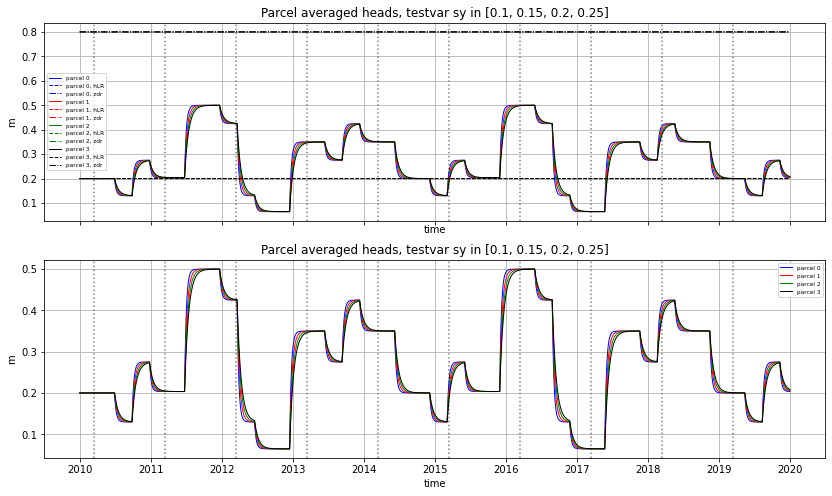

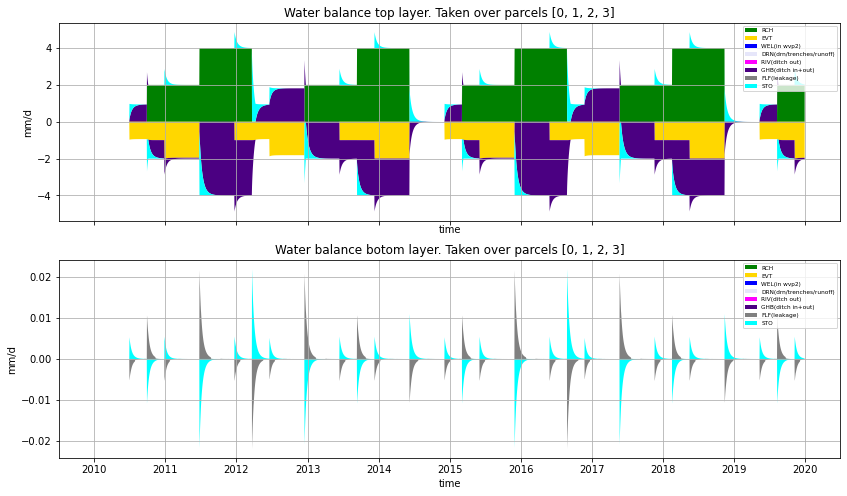

In [119]:
selection = pdata.index

testvals =  [pdata.loc[k, testvar] for k in selection]
testvals_str = ', '.join(['{:.4g}'.format(v) for v in testvals])

titles=['Parcel averaged heads, testvar {} in [{}]'.format(testvar, testvals_str),
        'Parcel averaged heads, testvar {} in [{}]'.format(testvar, testvals_str)]

ax = heads.plot(tdata=tdata,
               parcel_data=pdata,
               selection=list(pdata.index),
               titles=titles,
               size_inches=(14, 8), GXG=False)

ax = watbal.plot(parcel_data=pdata,
             tdata=tdata,
             selection=list(pdata.index),
             sharey=True)

# Compare analytical solutions

In the sequel we compare the results of all solution by placing their heads in the same figure.

The tested aspect is shown in the heading. In the first block thereafter, specific parameters are reset with new values to ensure the focus is on the aspect under focus.

# Analytical single layer above regional aquifer prescribed regional head $\phi$

# The heads have shape (nlay, nparcel, nt)

reading .pdbrc file in ~/Theo   ... done
> /Users/Theo/GRWMODELS/python/GGOR/src/analytic/ggor_analytical.py(1502)sim()
   1500         """
   1501         pdb.set_trace()
-> 1502         self.tdata, self.HDS, self.CBC = single_Layer_transient(
   1503                 solution_name=self.name,
   1504                 parcel_data = self.parcel_data,

ipdb> c
Sumulating L1f, NITER=1
Parcel 0.....................................3651 time steps
Parcel 1.....................................3651 time steps
Parcel 2.....................................3651 time steps
Parcel 3.....................................3651 time steps
Done.


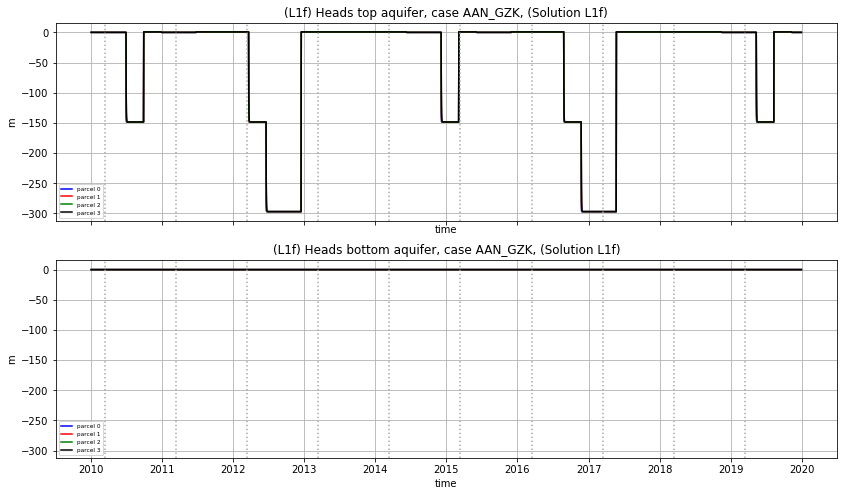

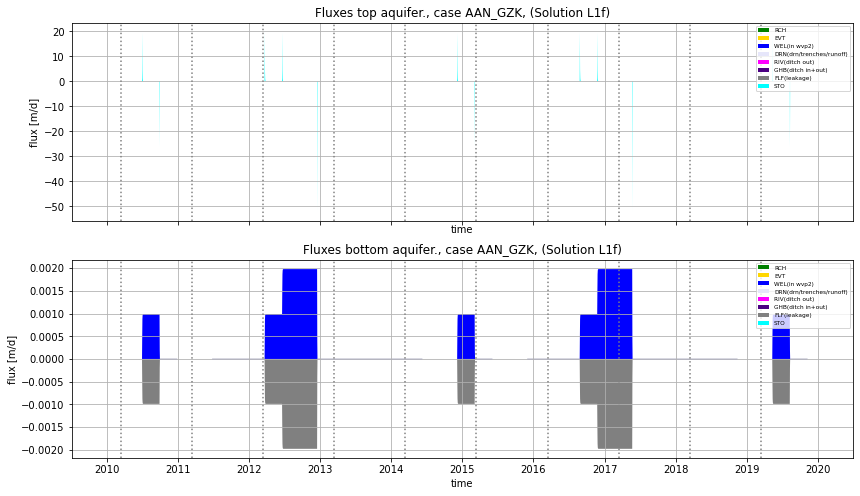

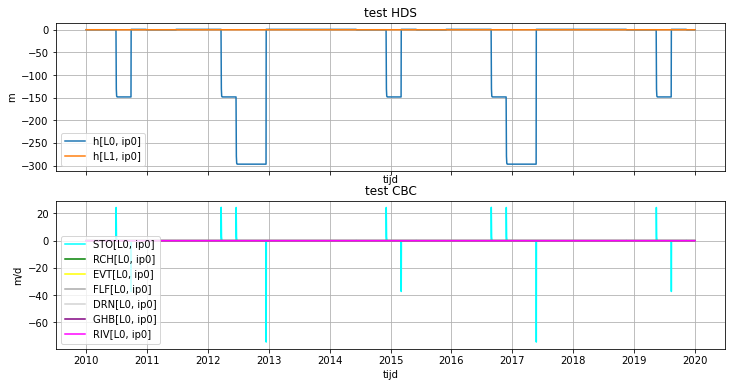

In [131]:
pdata['c_CB'] = 150000.

reload(ga)

use_w_not_c = True

l1f = ga.L1f(dirs=dirs, parcel_data=pdata)
l1f.sim(tdata=tdata, use_w_not_c=use_w_not_c)
l1f.plot_heads()
l1f.plot_cbc()
budget = l1f.CBC.get_budget()
obj = l1f

iparcel = 3
ilay = 0

if obj is not None:
    d   = obj.CBC.data
    hds = obj.HDS.data
    ax = ga.newfig2(['test HDS', 'test CBC'], 'tijd', ['m', 'm/d'])
    ax[0].plot(obj.tdata.index, hds[0, iparcel, :], label='h[L0, ip0]')
    ax[0].plot(obj.tdata.index, hds[1, iparcel, :], label='h[L1, ip0]')
    ax[0].legend()
    
    ax[1].plot(obj.tdata.index, d['STO'][ilay, iparcel, :], color='cyan', label='STO[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['RCH'][ilay, iparcel, :], color='green',  label='RCH[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['EVT'][ilay, iparcel, :], color='yellow',  label='EVT[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['FLF'][ilay, iparcel, :], color='darkgray', label='FLF[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['DRN'][ilay, iparcel, :], color='lightgray', label='DRN[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['GHB'][ilay, iparcel, :], color='purple', label='GHB[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['RIV'][ilay, iparcel, :], color='magenta', label='RIV[L0, ip0]')
    ax[1].legend()
    plt.show()

In [129]:
mu = 0.2
D1 = 10
b = 75
w1 = 2
c = [25, 100, 250, 2500, 25000, 250000]
for cc in c:
    print(mu / (1/cc + 1/w1 * D1 / b))

1.8750000000000002
2.6086956521739135
2.8301886792452833
2.9821073558648115
2.998201079352389
2.9998200107993522


# Analytical single layer above regional aquifer with prescribed $q_{up}$

reading .pdbrc file in ~/Theo   ... done
> /Users/Theo/GRWMODELS/python/GGOR/src/analytic/ggor_analytical.py(1500)sim()
   1498         """
   1499         pdb.set_trace()
-> 1500         self.tdata, self.HDS, self.CBC = single_Layer_transient(
   1501                 solution_name=self.name,
   1502                 parcel_data = self.parcel_data,

ipdb> c
Sumulating L1f, NITER=1
Parcel 0.....................................3651 time steps
Parcel 1.....................................3651 time steps
Parcel 2.....................................3651 time steps
Parcel 3.....................................3651 time steps
Done.


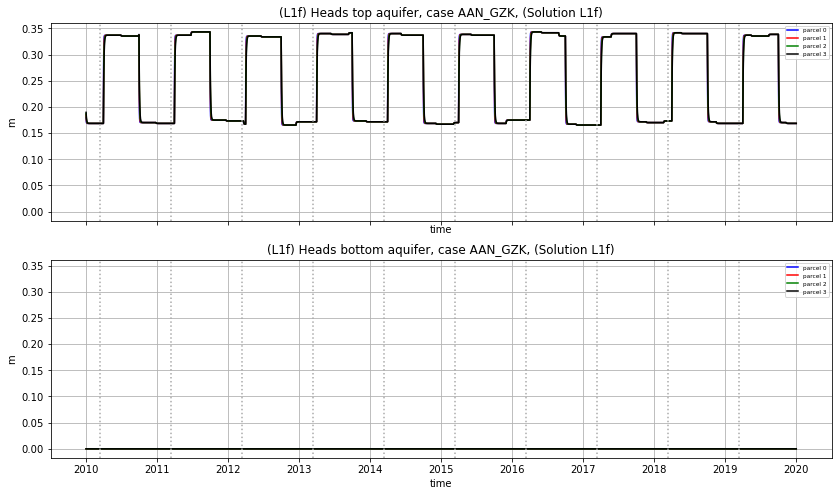

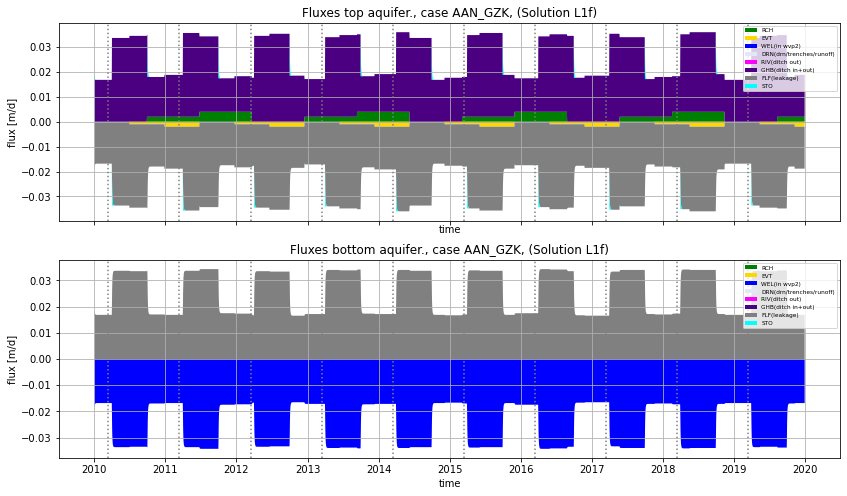

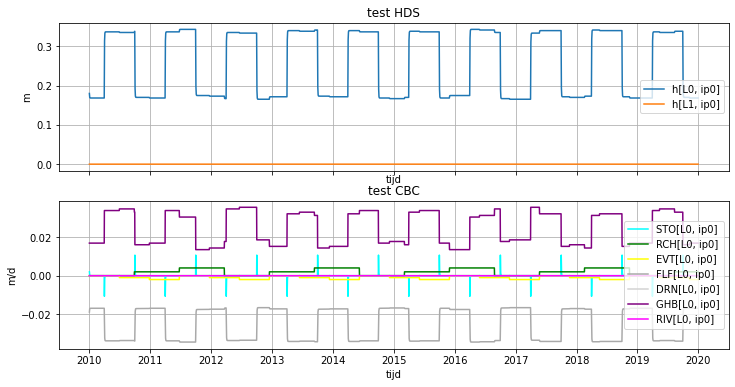

In [111]:
use_w_not_c = True

l1q = ga.L1f(dirs=dirs, parcel_data=pdata)
l1q.sim(tdata=tdata, use_w_not_c=use_w_not_c)
l1q.plot_heads()
l1q.plot_cbc()
budget = l1q.CBC.get_budget()
obj = l1q

if obj is not None:
    d   = obj.CBC.data
    hds = obj.HDS.data
    ax = ga.newfig2(['test HDS', 'test CBC'], 'tijd', ['m', 'm/d'])
    ax[0].plot(obj.tdata.index, hds[0, 0, :], label='h[L0, ip0]')
    ax[0].plot(obj.tdata.index, hds[1, 0, :], label='h[L1, ip0]')

    ax[0].legend()
    ax[1].plot(obj.tdata.index, d['STO'][0, 0, :], color='cyan', label='STO[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['RCH'][0, 0, :], color='green',  label='RCH[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['EVT'][0, 0, :], color='yellow',  label='EVT[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['FLF'][0, 0, :], color='darkgray', label='FLF[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['DRN'][0, 0, :], color='lightgray', label='DRN[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['GHB'][0, 0, :], color='purple', label='GHB[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['RIV'][0, 0, :], color='magenta', label='RIV[L0, ip0]')
    ax[1].legend()
    plt.show()

# Analytical two layer with prescribed $q_{up}$

reading .pdbrc file in ~/Theo   ... done
> /Users/Theo/GRWMODELS/python/GGOR/src/analytic/ggor_analytical.py(1500)sim()
   1498         """
   1499         pdb.set_trace()
-> 1500         self.tdata, self.HDS, self.CBC = single_Layer_transient(
   1501                 solution_name=self.name,
   1502                 parcel_data = self.parcel_data,

ipdb> c
Sumulating L1f, NITER=1
Parcel 0.....................................3651 time steps
Parcel 1.....................................3651 time steps
Parcel 2.....................................3651 time steps
Parcel 3.....................................3651 time steps
Done.


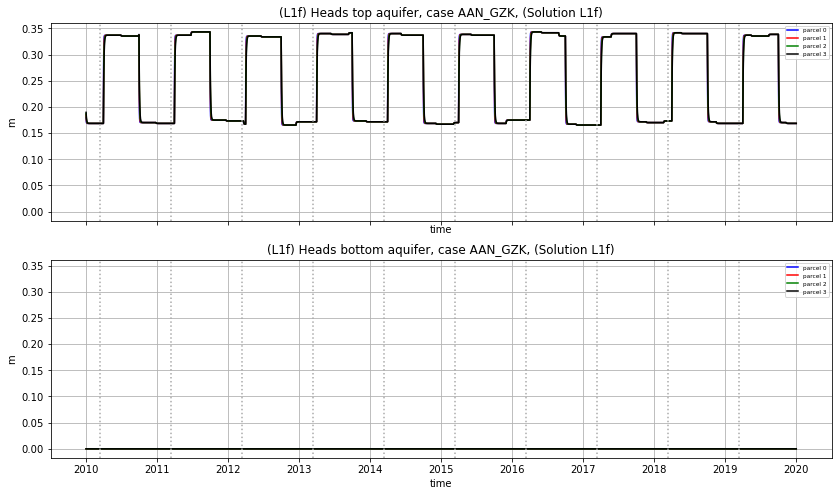

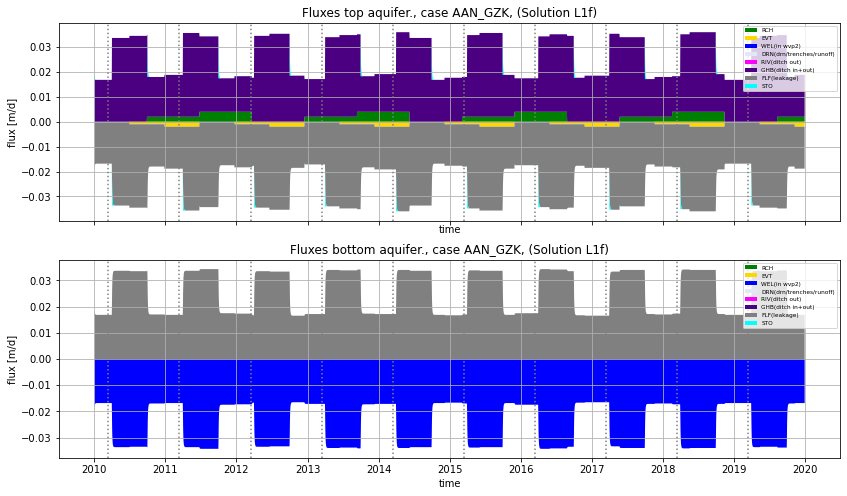

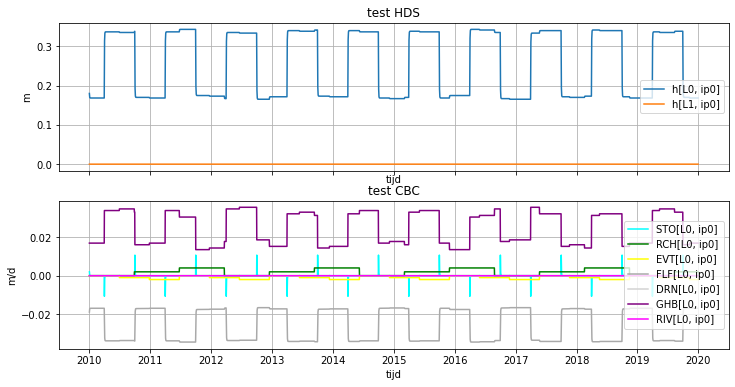

In [112]:
use_w_not_c = True

l2 = ga.L1f(dirs=dirs, parcel_data=pdata)
l2.sim(tdata=tdata, use_w_not_c=use_w_not_c)
l2.plot_heads()
l2.plot_cbc()
budget = l2.CBC.get_budget()
obj = l2


if obj is not None:
    d   = obj.CBC.data
    hds = obj.HDS.data
    ax = ga.newfig2(['test HDS', 'test CBC'], 'tijd', ['m', 'm/d'])
    ax[0].plot(obj.tdata.index, hds[0, 0, :], label='h[L0, ip0]')
    ax[0].plot(obj.tdata.index, hds[1, 0, :], label='h[L1, ip0]')

    ax[0].legend()
    ax[1].plot(obj.tdata.index, d['STO'][0, 0, :], color='cyan', label='STO[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['RCH'][0, 0, :], color='green',  label='RCH[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['EVT'][0, 0, :], color='yellow',  label='EVT[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['FLF'][0, 0, :], color='darkgray', label='FLF[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['DRN'][0, 0, :], color='lightgray', label='DRN[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['GHB'][0, 0, :], color='purple', label='GHB[L0, ip0]')
    ax[1].plot(obj.tdata.index, d['RIV'][0, 0, :], color='magenta', label='RIV[L0, ip0]')
    ax[1].legend()
    plt.show()

## No leakage, no entry resistance and no seepage.

The update of the original pdata consists of making sure the reistance of the confining bed is so large, that there is vertually no exchange between the two aquifers. At the same time, the seepage from the second to the first aquifer is set to zero, to prevent the model forcing the water upward.

We then set the dich resistance in the first aquifer to zero and that of the second to `np.inf`, ensuing the head at the ditches in the first aquifer is the given ditch water level and that there are effectively not ditches in the second aquifer.

## No entry/exit resistance and no net upward seepage

The only thing we change now is the resistance of the confining bed between the two aquifer. This means that there is now some exchange between the two aquifer depending on the differences between their heads. For the anlaytical two-layer solution and the numerical solution, there is even flow within the second aquifer. Due to this flow the head in the second aquifer is now somewhat curved. The head in the first aquifer is now lower than that in the of the single-layer solution due to some flow through the second aquifer. For the single layer-solution with underlying regional aquifer, only the average head in the second aquifer can be computed, and will, therefore be straigth. 

In [591]:
# With leakage
pdata['c_CB'] = 150.0 # d
props = pdata.iloc[0]

Except for the single layer, all solutions yield the same result. The MODFLOW and the analytical 2-layer solutions show that the head in the regional aquifer is curved. This is due to the flow that takes place in the regional aquifer caused by lekage. This flow is zero at both ends because closed there. The leakage follows the difference between the head in the top and regional aquifer.

## Add resistance between aquifer(s) and ditch in top aquifer

Setting the resistance between the ditch and the first aquifer to a value larger than zero causes the head at teh ends of the cross sections to change from the given water level in the ditch. 

In [594]:
# Entry resistance
pdata['wo_ditch'] = 10.0
pdata['wi_ditch'] = 20.0
props = pdata.iloc[0]

All solutions (except the single-layer) one have the same result. The head in the top aquifer at both ends is elevated from the ditchlevel (-0.3 m) due to the entry resistcance.

## Add upward seepage

Setting the seepage to a no-zero value will change the head in the regional aquifer to ensure the required seepage will be geneerated in the analytical and the numerical solutions.

In [597]:
# Entry resistance
pdata['q_up'] = 0.002
props = pdata.iloc[0]

All solutions yield the same results, except the single-layer solution, which has no underlying regional aquifer from which seepage could come. The upward seepage also causes the head in the regional aquifer to be above the head in the top aquifer.